# 1. Initial settings

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import time,os
import xarray as xr
import pickle
from scipy import stats
# import pytables
plt.rcParams.update({'font.size': 16})
################################
# import oggm and Get the default params
from oggm import cfg, utils, workflow, tasks, graphics
import oggm.cfg as cfg
cfg.initialize(logging_level='warning')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False
from oggm.core.massbalance import ScalarMassBalance
from oggm.core.flowline import FluxBasedModel,fa_sermeq_speed_law, k_calving_law
# from oggm.tests.funcs import bu_tidewater_bed
#no_mb = ScalarMassBalance()
mb_model = ScalarMassBalance()

################################
# import idealized bed topography function based on the Bassis & Ultee bed profile
import Idealized_Bed_Topography
from Idealized_Bed_Topography import bu_tidewater_bed
################################
#setting the workplace
rgi_id = 'Idealized_bed (bu)_new'
Figpath='/home/ruitang/OGGM-Ruitang/Results/Idealized_test_Vari_Tau'
# figure
Figpath_Folder_tif_path=Figpath+'/Tif/'+rgi_id+'/'
Figpath_Folder_png_path=Figpath+'/Png/'+rgi_id+'/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)
# data
Figpath_Folder_data_path=Figpath+'/Data/'+rgi_id+'/'
Figpath_Folder_data=utils.mkdir(Figpath_Folder_data_path,reset=True)
file_txt_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.txt'
#with open(file_txt_path_name,"w") as file:
#    file.write("************* Here is the model results ************* \n")
file_data_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.pickle'

2023-09-26 09:46:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-09-26 09:46:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-09-26 09:46:01: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-09-26 09:46:02: oggm.cfg: PARAMS['cfl_number'] changed from `0.02` to `0.01`.


## 1.1 show the OGGM Version and systerm path

In [2]:

from oggm.utils import show_versions
show_versions()

'# OGGM environment: \n## System info:\n    python: 3.11.5.final.0\n    python-bits: 64\n    OS: Linux\n    OS-release: 4.18.0-477.13.1.el8_8.x86_64\n    machine: x86_64\n    processor: x86_64\n## Packages info:\n    oggm: 1.6.1.dev54+g9b826a7\n    numpy: 1.25.2\n    scipy: 1.11.2\n    pandas: 2.1.0\n    geopandas: 0.13.2\n    netCDF4: 1.6.4\n    matplotlib: 3.7.2\n    rasterio: 1.3.8\n    fiona: 1.9.4\n    pyproj: 3.6.0\n    shapely: 2.0.1\n    xarray: 2023.8.0\n    dask: 2023.9.1\n    salem: 0.0.0\n    OGGM git identifier: 96a9b56c4bacef12dcbbd25f0bdde8b32696c612'

In [3]:
import sys
print(sys.path)

['/home/ruitang/OGGM-Ruitang/oggm_Ruitang/oggm/FA_Sermeq_R&L', '/home/ruitang/miniconda3/envs/oggm_env/lib/python311.zip', '/home/ruitang/miniconda3/envs/oggm_env/lib/python3.11', '/home/ruitang/miniconda3/envs/oggm_env/lib/python3.11/lib-dynload', '', '/home/ruitang/miniconda3/envs/oggm_env/lib/python3.11/site-packages']


# 2. Test on an idealized profile
## 2.1 Bu bed topography


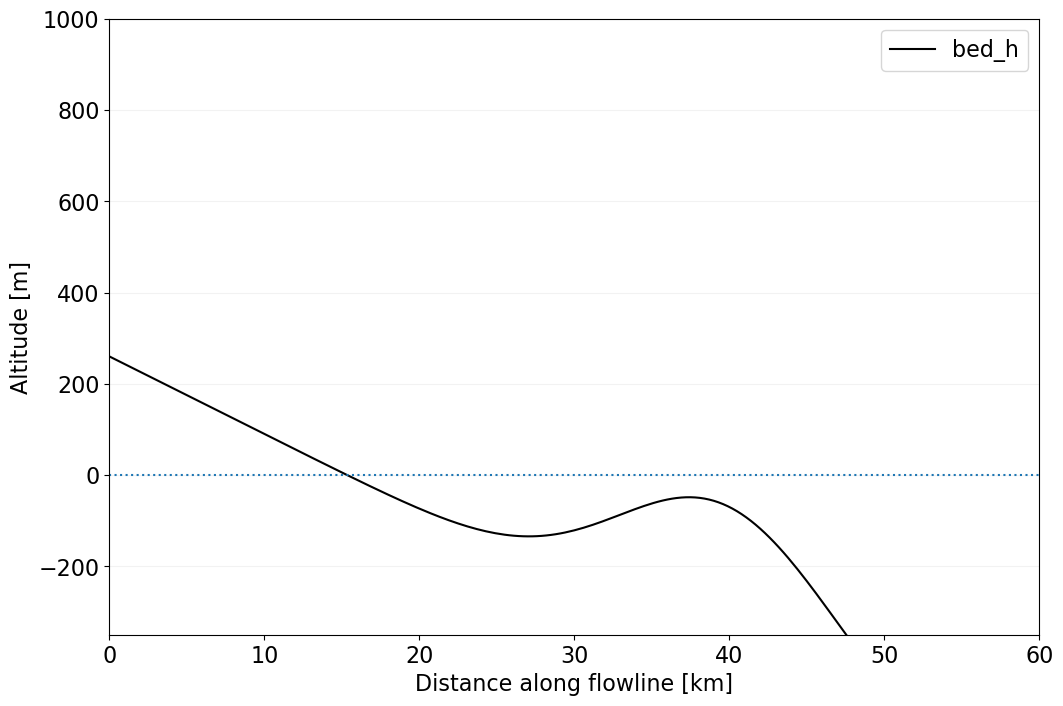

In [4]:
# import the idealized bed, BU from Lizz
bu_fl = bu_tidewater_bed()[0]
xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
# ax.plot(xc, bu_fl.surface_h, color='b',label='surface_h') #surface_h=bed_h
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(*xc[[0, -1]]); plt.ylim(-350, 1000); plt.ylabel('Altitude [m]');
plt.xlabel('Distance along flowline [km]');
plt.grid(axis='y', color='0.95')
plt.legend();
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_bed_profile'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_bed_profile'+'.png',dpi=600,bbox_inches='tight')

## 2.2 Put a k-calving profile on top of this and check what viscoplastic calving rates we'd get


In [5]:
model = FluxBasedModel(bu_fl, mb_model=mb_model,
                       is_tidewater=True,
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.03,  # default is 0
                       calving_k=None, # default is 2.4
                       do_kcalving=True,
                       calving_law=fa_sermeq_speed_law
                      )
# long enough to reach approx. equilibrium
ds = model.run_until_and_store(15000)
df_diag = model.get_diagnostics()

# save the k-calving results in the dataset
my_data_output={'fa_sermeq_calving_m3a_TimeSeri':ds.calving_m3,'fa_sermeq_calving_rate_ma_TimeSeri':ds.calving_rate_myr,'fa_sermeq_calving_myr_Mean':model.calving_rate_myr}
# print the k-calving rate
with open(file_txt_path_name,"a") as file:
    print('--------------- fa_sermeq_Calving results ---------------',file=file)
    print('The averaged fa_sermeq_calving rate over the 15000 years is {:.2f} m per year, '
      '\n and {:.2f} m3 per year \n'.format(model.calving_rate_myr,model.calving_m3_since_y0/6000),file=file)
## TODO: save the data in a picklds file


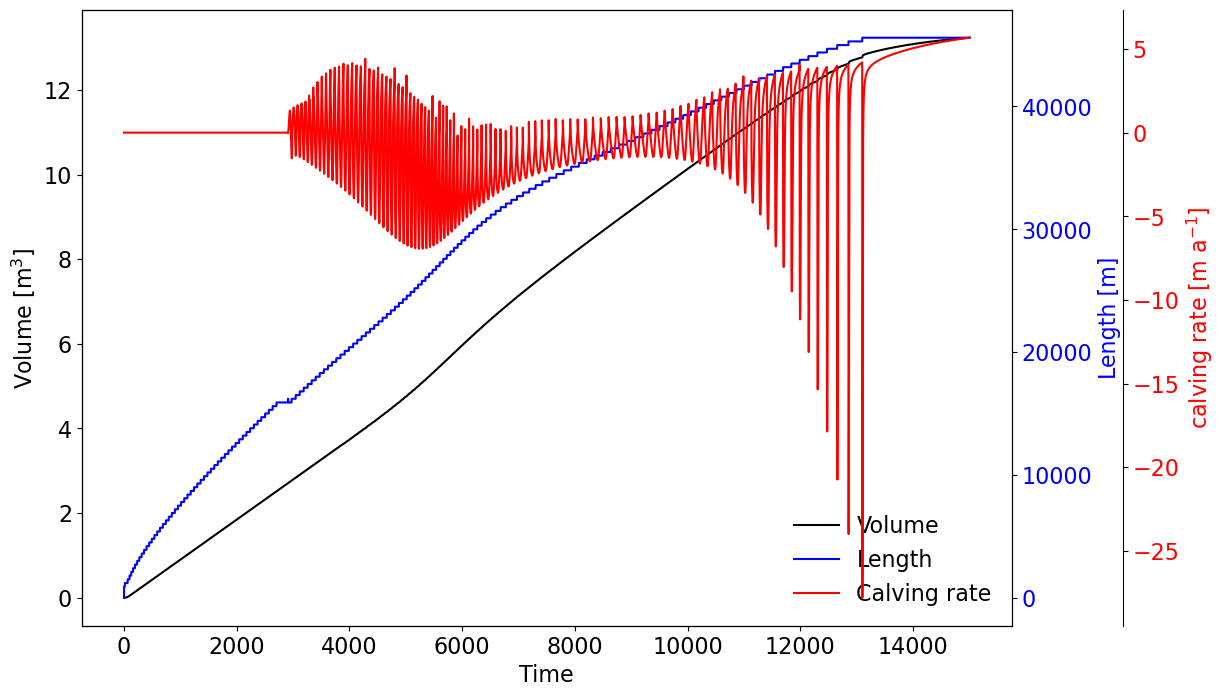

In [6]:
# the Bu-bed in SERMeq, bed_h
plt.figure(1,figsize=(12, 8))
# the timeseries of volume
ax1=plt.subplot(1,1,1)
ax1=(ds.volume_m3*1e-9).plot(color='k',label='Volume')
ax1=plt.gca()
ax1.set_ylabel('Volume [m$^{3}$]',color='k')
ax1.set_xlabel('Time',color='k')
ax1.tick_params(axis='y',labelcolor='k')

# the timeseries of length
ax2=ax1.twinx()
ax2=plt.plot(ds.length_m.values,color='b',label='Length')
ax2=plt.gca()
plt.ylabel('Length [m]',color='b')
plt.tick_params(axis='y',labelcolor='b')

# the timeseries of calving rate
ax3=ax1.twinx()
plt.plot(ds.calving_rate_myr.values,color='r',label='Calving rate')
ax3=plt.gca()
ax3.spines['right'].set_position(('outward', 80)) 
plt.ylabel('calving rate [m a$^{-1}$]',color='r')
plt.tick_params(axis='y',labelcolor='r')
####################################################################################
# Combine the legends from all axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='lower right',frameon=False)

####################################################################################
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Volume_change_Timeseries'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Volume_change_Timeseries'+'.png',dpi=600,bbox_inches='tight')


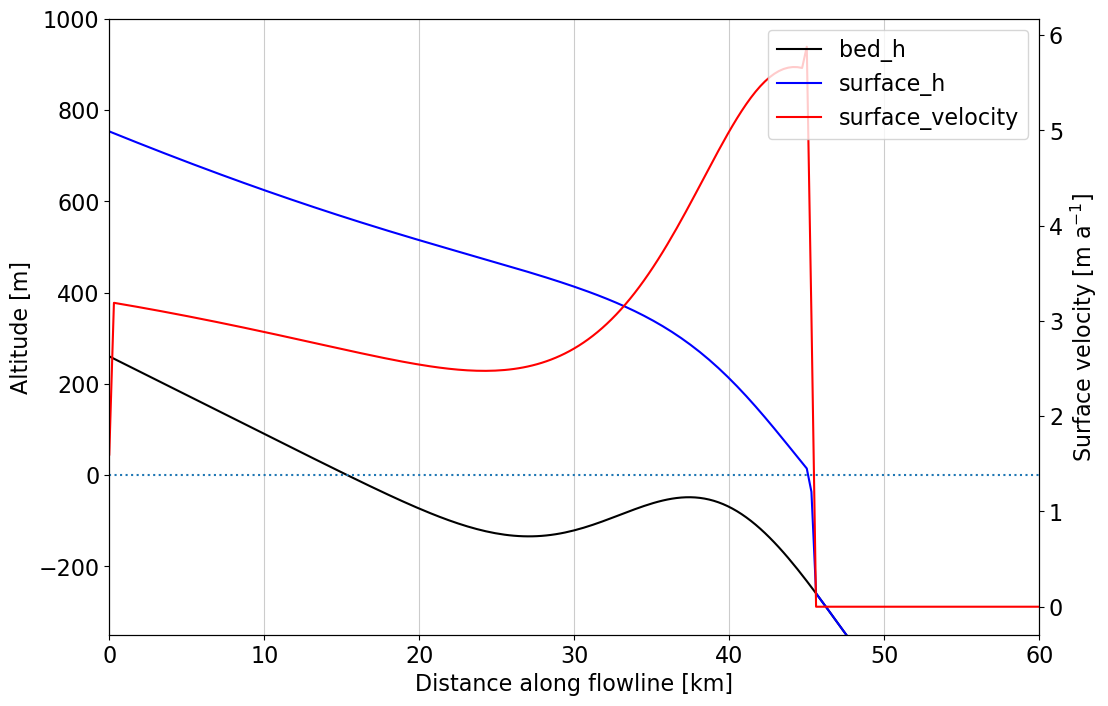

In [7]:
# the Bu-bed in SERMeq, bed_h
plt.figure(1,figsize=(12, 8))
# plt.subplot(2,1,1)
# lns1,=plt.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
# plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
# plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]')
# plt.grid(axis='x', color='0.8')
# plt.legend()
# the k-calving result, surface_h
ax1=plt.subplot(1,1,1)
lns2,=ax1.plot(xc, df_diag.bed_h, color='k',label='bed_h')
lns3,=ax1.plot(xc, df_diag.surface_h, color='b',label='surface_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]');plt.xlabel('Distance along flowline [km]')
plt.grid(axis='x', color='0.8')
ax2=ax1.twinx()
lns4,=ax2.plot(xc, df_diag.ice_velocity*31536000, color='r',label='surface_velocity')
plt.ylabel('Surface velocity [m a$^{-1}$]')
# plt.ylim([0,18])
legend_profile=plt.legend(handles=[lns2,lns3,lns4],loc='upper right')

#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Ideal_bed_fa_sermeq_calving_profile_with_volotcity'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Ideal_bed_fa_sermeq_calving_profile_with_volotcity'+'.png',dpi=600,bbox_inches='tight')

In [8]:
ds

<xarray.Dataset>
Dimensions:           (time: 15001)
Coordinates:
  * time              (time) float64 0.0 1.0 2.0 3.0 ... 1.5e+04 1.5e+04 1.5e+04
    calendar_year     (time) int64 0 1 2 3 4 5 ... 14996 14997 14998 14999 15000
    calendar_month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year        (time) int64 0 1 2 3 4 5 ... 14996 14997 14998 14999 15000
    hydro_month       (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Data variables:
    volume_m3         (time) float64 0.0 4.336e+03 ... 1.323e+10 1.323e+10
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 ... 1.73e+09 1.73e+09 1.73e+09
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 ... 1.73e+09 1.73e+09 1.73e+09
    area_m2           (time) float64 0.0 5.4e+05 5.4e+05 ... 2.736e+07 2.736e+07
    length_m          (time) float64 0.0 900.0 900.0 ... 4.56e+04 4.56e+04
    calving_m3        (time) float64 0.0 0.0 0.0 ... 9.086e+08 9.094e+08
    calving_rate_myr  (time) float64 0.0 0.0 0.0 0.0 ... 5.671 5.672 5.672 5.672
Attributes:
    description:          OGGM model output
    oggm_version:         1.6.1.dev54+g9b826a7
    calendar:             365-day no leap
    creation_date:        2023-09-26 07:46:02
    water_level:          0
    glen_a:               2.4e-24
    fs:                   0.0
    mb_model_class:       ScalarMassBalance
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0

In [9]:
df_diag

,surface_h,bed_h,ice_thick,section_width,section_area,slope,ice_flux,ice_velocity,surface_ice_velocity,shape_fac,tributary_flux
distance_along_flowline,,,,,,,,,,,
0.0,753.003831,260.000039,493.003791,600.0,295802.274703,0.006864,0.029991,5.063042e-08,6.328802e-08,1.0,0.0
300.0,748.885656,254.900050,493.985606,600.0,296391.363457,0.013703,0.029974,1.011305e-07,1.264131e-07,1.0,0.0
600.0,744.781987,249.800063,494.981924,600.0,296989.154263,0.013655,0.029957,1.008685e-07,1.260856e-07,1.0,0.0
900.0,740.692958,244.700080,495.992878,600.0,297595.726607,0.013605,0.029939,1.006038e-07,1.257548e-07,1.0,0.0
1200.0,736.618700,239.600101,497.018599,600.0,298211.159206,0.013556,0.029922,1.003364e-07,1.254205e-07,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
58800.0,-729.388310,-729.388310,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0
59100.0,-735.585804,-735.585804,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0
59400.0,-741.679976,-741.679976,0.000000,600.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.0,0.0


In [10]:
model.calving_rate_myr

5.67245945150122

In [11]:
model.calving_m3_since_y0

909435156.9811078

In [12]:
model.calving_limiter_frac

0.0

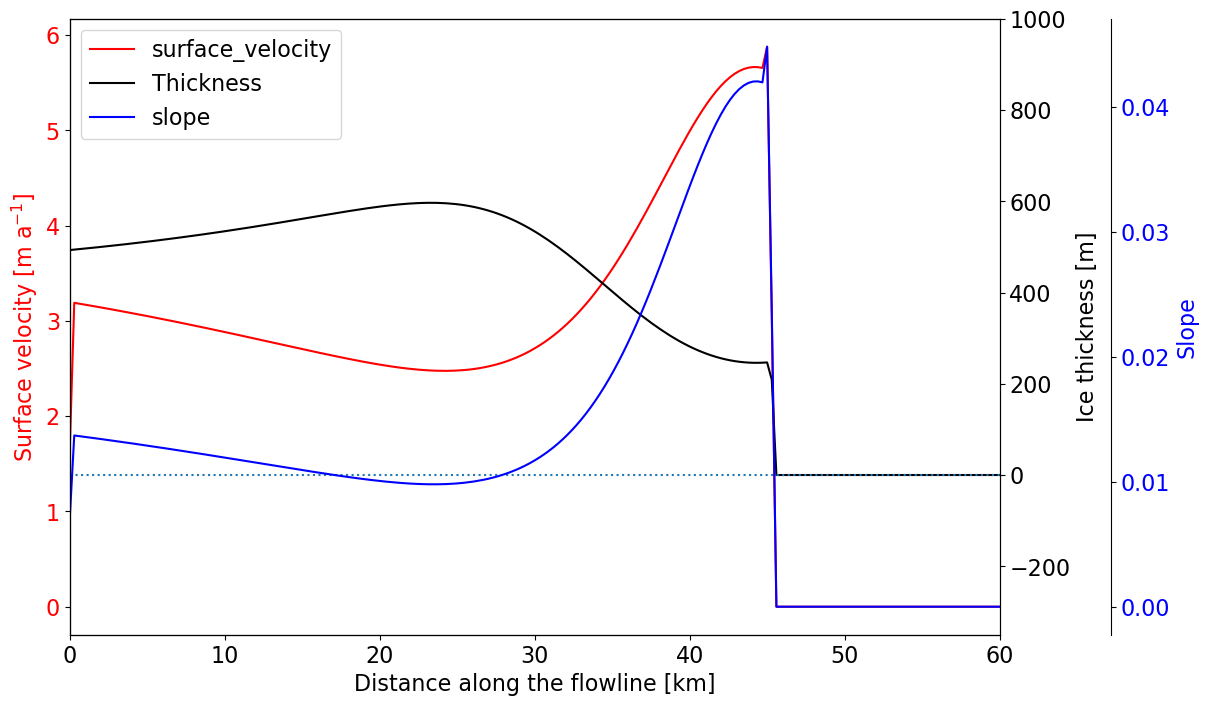

In [21]:
# the Bu-bed in SERMeq, bed_h
plt.figure(1,figsize=(12, 8))
# plt.subplot(2,1,1)
# lns1,=plt.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
# plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
# plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]')
# plt.grid(axis='x', color='0.8')
# plt.legend()
# the k-calving result, surface_h
ax1=plt.subplot(1,1,1)
lns2,=ax1.plot(xc, df_diag.ice_velocity*31536000, color='r',label='surface_velocity')
# ax3.spines['right'].set_position(('outward', 60)) 
# plt.ylabel('Surface velocity [m a$^{-1}$]')
ax1.set_xlabel('Distance along the flowline [km]',color='k')
ax1.set_ylabel('Surface velocity [m a$^{-1}$]',color='r')
ax1.tick_params(axis='y',labelcolor='r')



####################################################################################
# Ice thickness
ax2=ax1.twinx()
lns3,=ax2.plot(xc, df_diag.ice_thick, color='k',label='Thickness')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Ice thickness [m]');plt.xlabel('Distance along flowline [km]')
plt.grid(axis='x', color='0.8')

# # slope
ax3=ax1.twinx()
lns4,=ax3.plot(xc, df_diag.slope, color='b',label='slope')
ax3.spines['right'].set_position(('outward', 80))  # 调整右坐标轴的位置
ax3.set_ylabel('Slope',color='b')
ax3.tick_params(axis='y',labelcolor='b')



# plt.ylim([0,18])
legend_profile=plt.legend(handles=[lns2,lns3,lns4],loc='upper left')

#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Ideal_bed_kcalving_profile_with_volotcity'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Ideal_bed_kcalving_profile_with_volotcity'+'.png',dpi=600,bbox_inches='tight')

## 2.3 Frontal_ablation_Sermeq_Speed

In [14]:
### last point above the water level
######################prepare the input data
surface_profile = df_diag.surface_h
bed_profile = df_diag.bed_h
x = df_diag.index
model_U = df_diag.ice_velocity * cfg.SEC_IN_YEAR ## convert ice velocity to m/a
with open(file_txt_path_name,"a") as file:
    print('the maximum velocity is {:.2f}'.format(max(model_U)),file=file)
# Find index of the terminus
term_index = int(np.argwhere(surface_profile.values>0)[-1])
print(term_index)

150


/tmp/ipykernel_3388146/3201200617.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term_index = int(np.argwhere(surface_profile.values>0)[-1])


In [15]:
# We do calving only if there is some ice above wl
last_above_wl = np.nonzero((df_diag.surface_h > model.water_level) & (df_diag.ice_thick > 0))[0][-1]
print (last_above_wl)
# if df_diag.bed_h[last_above_wl] > model.water_level:
#     print (last_above_wl)
    # continue

150


In [22]:

input_profile = (x.values[:term_index+1], ## slice up to index+1 to include the last nonzero value
                 surface_profile.values[:term_index+1],
                 bed_profile.values[:term_index+1])
input_velocity = model_U.values[:term_index+1]

# save the mass balance data on the flowline
my_data_output['Surface massblance ma']=mb_model.get_annual_mb(heights=surface_profile.values)

with open(file_txt_path_name,"a") as file:
    print('the mean surface mass balance along the flowline is {:.2f}\n'.format(np.mean(mb_model.get_annual_mb(heights=surface_profile.values))),file=file)

## TODO: check this is surface mass balance or whole mass balance?

###################### do the Sermeq fa calculation
# call the fa_from_velocity function to calculation the frontal ablation
# SQFA = FA_Sermeq_speed_law(profile=input_profile,
#             model_velocity=input_velocity, v_scaling=1, Terminus_mb=0,verbose=True,tau0=150e3, yield_type='constant', mu=0.01)
# model_new = FluxBasedModel(bu_fl, mb_model=mb_model,
#                        is_tidewater=True,
#                        calving_use_limiter=True,  # default is True
#                        flux_gate=0.06,  # default is 0
#                        calving_k=None, # default is 2.4
#                        do_kcalving=True,
#                        calving_law=fa_sermeq_speed_law
#                       )

SQFA = fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=1, verbose=True,
                     tau0=150e3, yield_type='variable', mu=0.01,trim_profile=0)

#SQFA is a dictionary, including se_terminus','bed_terminus','Thickness_termi','Hy_thickness','Velocity_termi','dLdt','Sermeq_fa'

# save the data
my_data_output['Sermeq frontal ablation ma']= SQFA
# with open(file_data_path_name,'wb')as file:
#     pickle.dump(my_data_output,file)

with open(file_txt_path_name,"a") as file:
    print('--------------- Sermeq results ---------------',file=file)
    print('the terminus mass balance is {:.2f} m per year\n'.format(SQFA['Terminus_mb']),file=file)
    print('the terminus velocity is {:.2f} m per year\n'.format(SQFA['Velocity_termi']),file=file)
    print('the Sermeq length change rate is {:.2f} m per year\n'.format(SQFA['dLdt']),file=file)
    # print('the Sermeq frontal ablation is {:.2f} m per year\n'.format(mb_model.get_annual_mb(heights=surface_profile.values)),file=file)



For inspection on debugging - all should be DIMENSIONAL (m/a):
last_index=-1
se_terminus=14.31878653375162
bed_terminus=-232.41972592500827
se_adj=26.8886870695963
bed_adj=-219.27110041157061
Thicknesses: Hterm 246.73851245875989, Hadj 246.15978748116692
Hy_terminus=277.8482827695549
Hy_adj=264.2881239209508
U_terminus=5.648143192150676
U_adj=5.660111577629467
dUdx=-0.03989461826263586
dx_term=0.29999999999999716
Checking dLdt: terminus_mb = 0.0. 
 H dUdx = -9.843538765232847. 
 U dHdx = 10.895738474397714.
Denom: dHydx = 45.200529495347396 
 dHdx = 1.9290832586432498
Viscoplastic dLdt=-0.02431625935054511
Terminus surface mass balance ma= 0.0
Sermeq frontal ablation ma=5.672459451501221


In [17]:
len(mb_model.get_annual_mb(heights=surface_profile.values))

201

In [18]:
SQFA

{'se_terminus': 14.31878653375162,
 'bed_terminus': -232.41972592500827,
 'Thickness_termi': 246.73851245875989,
 'Width_termi': 600.0,
 'Hy_thickness': 278.06761439313027,
 'Velocity_termi': 5.648143192150676,
 'Terminus_mb': 0.0,
 'dLdt': -0.023801841872990153,
 'Sermeq_fa': 5.671945034023666}

# 3. Sensitive tests of yield strength, terminus surface mass balance, ice speed scaling

## 3.1 Test on yield strength


 The sensitive tests on yield strength is successful

For inspection on debugging - all should be DIMENSIONAL (m/a):
last_index=-1
se_terminus=14.31878653375162
bed_terminus=-232.41972592500827
se_adj=26.8886870695963
bed_adj=-219.27110041157061
Thicknesses: Hterm 246.73851245875989, Hadj 246.15978748116692
Hy_terminus=255.6201831415609
Hy_adj=242.0573082772208
U_terminus=5.648143192150676
U_adj=5.660111577629467
dUdx=-0.03989461826263586
dx_term=0.29999999999999716
Checking dLdt: terminus_mb = 0.0. 
 H dUdx = -9.843538765232847. 
 U dHdx = 10.895738474397714.
Denom: dHydx = 45.20958288113401 
 dHdx = 1.9290832586432498
Viscoplastic dLdt=-0.02431117289177712
Terminus surface mass balance ma= 0.0
Sermeq frontal ablation ma=5.672454365042453
For inspection on debugging - all should be DIMENSIONAL (m/a):
last_index=-1
se_terminus=14.31878653375162
bed_terminus=-232.41972592500827
se_adj=26.8886870695963
bed_adj=-219.27110041157061
Thicknesses: Hterm 246.73851245875989, Hadj 246.159787481

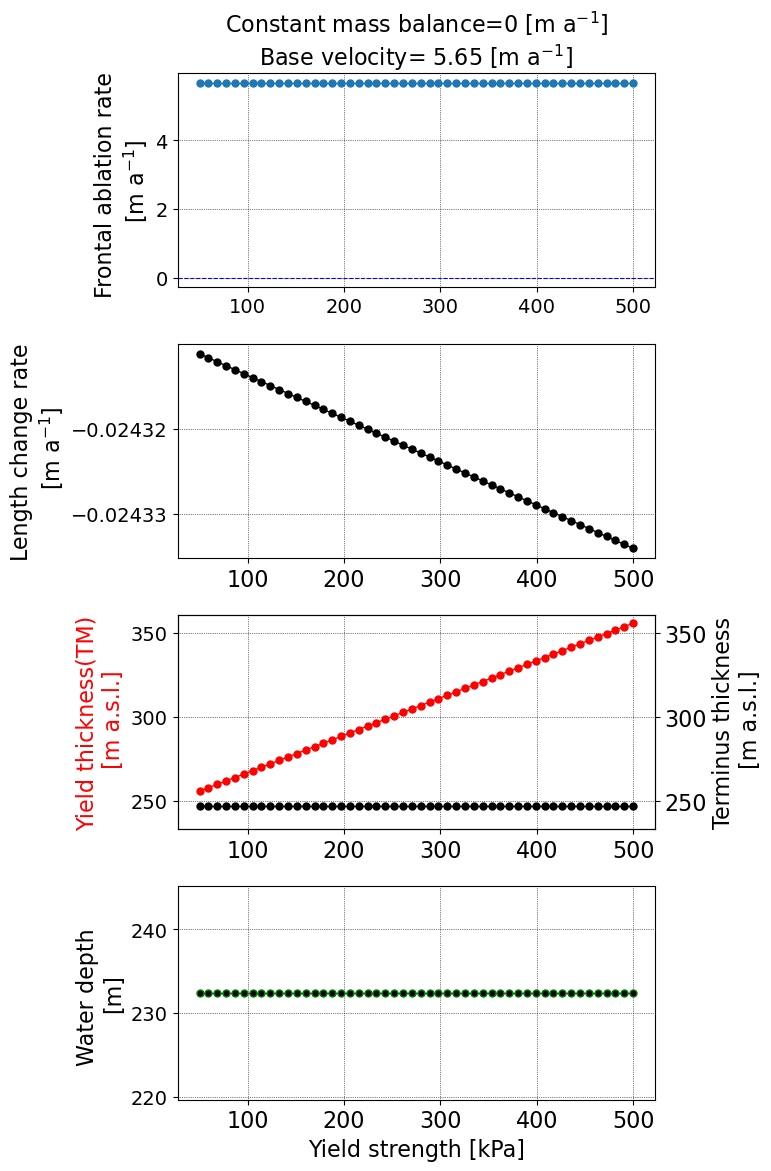

In [19]:
# set variable range for the yield strength
ty_tests = np.linspace(50e3, 500e3, num=50)
# calculate the Sermeq frontal ablation

# SQFA = fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=1, verbose=True,
#                      tau0=150e3, yield_type='constant', mu=0.01,
#                      trim_profile=0)
Fa_results_ty= [fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=1, verbose=False,
                     tau0=ty, yield_type='variable', mu=0.01,
                     trim_profile=0) for ty in ty_tests]
fa_results=[obj['Sermeq_fa'] for obj in Fa_results_ty]
fa_results_dLdt=[obj['dLdt'] for obj in Fa_results_ty]
fa_results_U=[obj['Velocity_termi'] for obj in Fa_results_ty]
fa_results_Hy=[obj['Hy_thickness'] for obj in Fa_results_ty]
fa_results_Ht=[obj['Thickness_termi'] for obj in Fa_results_ty]
fa_results_Bt=[obj['bed_terminus'] for obj in Fa_results_ty]
fa_results_Wd=(-1)*np.array(fa_results_Bt)
# if there is a changing point where the frontal ablation change from negative to positive, then insert a subplot for the negative part
if (np.array(fa_results)<0).any():
    term_Posi_FA_index = int(np.argwhere(np.array(fa_results)<0)[0])
    Ty_CP=ty_tests[term_Posi_FA_index] # the changing point of yield strength
    dLdt_CP=Fa_results_ty[term_Posi_FA_index]['dLdt']
    fa_CP=Fa_results_ty[term_Posi_FA_index]['Sermeq_fa']
    mb_CP=Fa_results_ty[term_Posi_FA_index]['Terminus_mb']
    print("Something is wrong, when the yield strength is larger than {} KPa, the model frontal ablation is negative\n"
          "the length change rate is {} m/a \n"
          "the frontal ablation rate is {} m/a \n"
          "the surface mass balance at the terminus is {} m/a \n".format(Ty_CP,dLdt_CP,fa_CP,mb_CP))
    if dLdt_CP>0:
        print("the terminus is advancing")
else:
    print("\n The sensitive tests on yield strength is successful\n")
################# check the model runs well and the results make sense
t=[]
for ty in ty_tests[0:3]:
    t.append(fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=1, verbose=True,
                     tau0=ty, yield_type='variable', mu=0.01,
                     trim_profile=0))
    
#################

#######################################################################
#######################################################################
#######################################################################
# plot the sensitive tests results on different yield strength with the constant surface mass balance and base velocity
plt.figure(1,figsize=(8,12))
# subplot(frontal ablation)
ax1=plt.subplot(4,1,1)
lns1,=ax1.plot(1e-3*ty_tests, fa_results,color='C0', linestyle='-', linewidth=1,marker='o',
               markersize=5,markeredgecolor='C0', markerfacecolor='C0',label='frontal ablation rate')
plt.axhline(0, color='b', ls='--',linewidth=0.8)
# plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Frontal ablation rate \n[m a$^{-1}$]',fontsize=16,color='k')
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,color='k')
ax1.spines["top"].set_color('k')
ax1.spines["bottom"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
# ax1.set_ylim(10, 12)
ax1.set_title("Constant mass balance=0 [m a$^{-1}$]\n" + "Base velocity= {:.2f}".format(fa_results_U[0])+" [m a$^{-1}$]",fontsize=16)

# subplot(length change rate dL/dt)
# ax2=ax1.twinx()
ax2=plt.subplot(4,1,2)
lns2,=ax2.plot(1e-3*ty_tests, fa_results_dLdt,color='k', linestyle='-', linewidth=1,marker='o',
               markersize=5,markeredgecolor='black', markerfacecolor='k',label='length change rate')
# plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Length change rate\n [m a$^{-1}$]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.yticks(fontsize=14,color='k')


# ax1.set_ylim(y12_min, y12_max)
# ax1.set_ylim(8, 12)
#
# ax2.set_ylim(3, 4)


# Yield terminus Thickness
ax3=plt.subplot(4,1,3)
lns3,=ax3.plot(1e-3*ty_tests, fa_results_Hy,color='r', linestyle='-', linewidth=1,marker='o',
               markersize=5,markeredgecolor='r', markerfacecolor='r',label='Yield thickness')
# plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Yield thickness(TM)\n [m a.s.l.]',fontsize=16,color='r')
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.yticks(fontsize=14,color='k')

ax32=ax3.twinx()
lns32,=ax32.plot(1e-3*ty_tests, fa_results_Ht,color='k', linestyle='-', linewidth=1,marker='o',
               markersize=5,markeredgecolor='black', markerfacecolor='k',label='Terminus thickness')
plt.ylabel('Terminus thickness\n [m a.s.l.]',fontsize=16)
# set the same axis limitation
y1_min, y1_max = ax3.get_ylim()
y2_min, y2_max = ax32.get_ylim()
y12_min=min(y1_min,y2_min)
y12_max=max(y1_max,y2_max)
ax3.set_ylim(y12_min,y12_max)
ax32.set_ylim(y12_min,y12_max)


# bed_elevation
ax4=plt.subplot(4,1,4)
lns4,=ax4.plot(1e-3*ty_tests, fa_results_Wd,color='g', linestyle='-', linewidth=1,marker='o',
               markersize=5,markeredgecolor='g', markerfacecolor='k',label='Water depth')
plt.xlabel('Yield strength [kPa]',fontsize=16)
plt.ylabel('Water depth \n[m]',fontsize=16)
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.yticks(fontsize=14,color='k')

plt.tight_layout()
#
#
# # add the legend
# # plt.legend(handles=[lns1,lns2],loc='upper left',handlelength=1,fontsize=16)
# # save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Yeild strength on Fa'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Yeild strength on Fa'+'.png',dpi=600,bbox_inches='tight')

## 3.2 Tests on velocity scaling

0.0
1.0
2.0


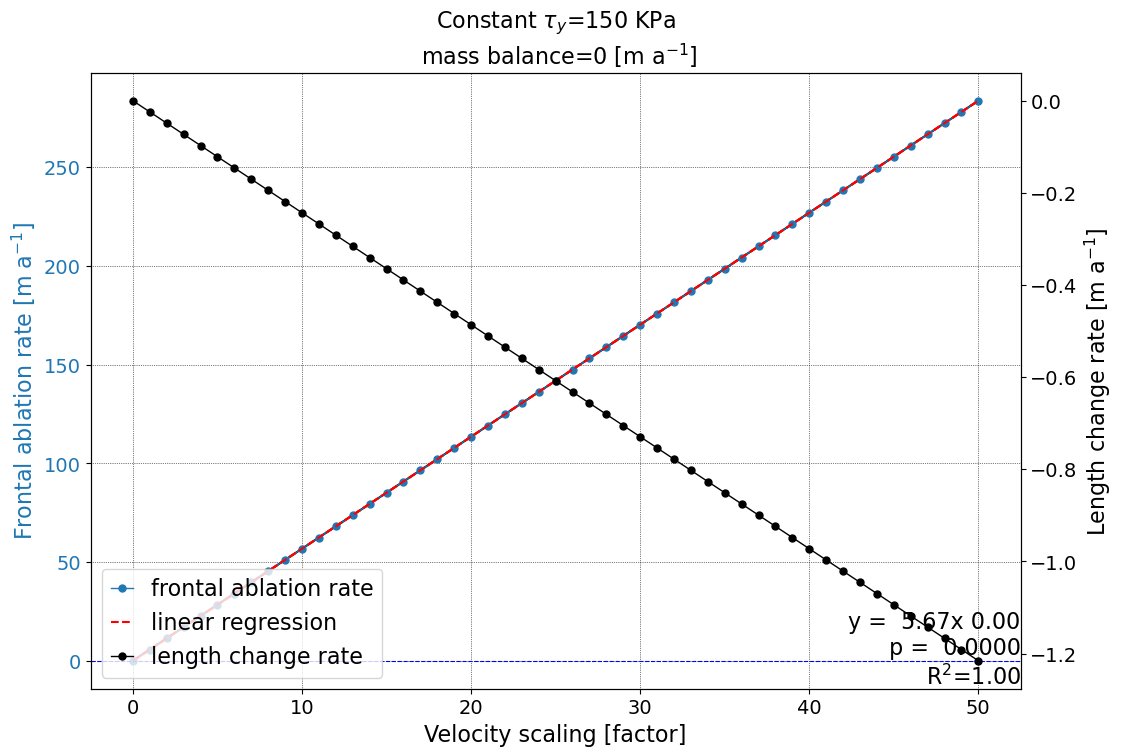

In [20]:
# set variable range for velocity scaling
v_scalings = np.linspace(0,50,num=51)

# Fa_results_v = [fa_from_velocity(profile=input_profile, model_velocity=input_velocity,v_scaling=vs , Terminus_mb=0, verbose=True,
#                     tau0=150e3, yield_type='constant', mu=0.01,trim_profile=1) for vs in v_scalings]
Fa_results_v =[]
for vs in v_scalings:
    Fa_results_v.append(fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=vs, verbose=False,
                     tau0=ty, yield_type='variable', mu=0.01,
                     trim_profile=0))
fa_results_v=[obj['Sermeq_fa'] for obj in Fa_results_v]
fa_results_v_dLdt=[obj['dLdt'] for obj in Fa_results_v]
fa_results_v_U=[obj['Velocity_termi'] for obj in Fa_results_v]


fa_results_v_Hy=[obj['Hy_thickness'] for obj in Fa_results_v]
fa_results_v_Ht=[obj['Thickness_termi'] for obj in Fa_results_v]
fa_results_v_Bt=[obj['bed_terminus'] for obj in Fa_results_v]
fa_results_v_Wd=(-1)*np.array(fa_results_v_Bt)

################# check the model runs well and the results make sense
t=[]
for vs in v_scalings[0:3]:
    print(vs)
    t.append(fa_sermeq_speed_law(model=model,last_above_wl=term_index,v_scaling=vs, verbose=False,
                     tau0=ty, yield_type='variable', mu=0.01,
                     trim_profile=0))
#################

#######################################################################
#######################################################################
#######################################################################
# plot the sensitive tests results on different yield strength with the constant surface mass balance and base velocity
plt.figure(1,figsize=(12,8))
# subplot(frontal ablation)
ax1=plt.subplot(1,1,1)
fa_results_v_LF=stats.linregress(v_scalings, fa_results_v)
k_v=fa_results_v_LF.slope
b_v=fa_results_v_LF.intercept
r2_v=(fa_results_v_LF.rvalue)**2
p_v=fa_results_v_LF.pvalue
ax1.plot(v_scalings, fa_results_v,'k',v_scalings, k_v*v_scalings+b_v,'--r')
lns1,=ax1.plot(v_scalings, fa_results_v,'C0',linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='C0', markerfacecolor='C0',label='frontal ablation rate')
lns2,=ax1.plot(v_scalings, k_v*v_scalings+b_v,'--r',label='linear regression')


plt.axhline(0, color='b', ls='--',linewidth=0.8)
#add fitted regression equation to plot
plt.annotate('y = '  + ' {:.2f}'.format(k_v) + 'x '+ '{:.2f}'.format(b_v)+
         '\n p = ' +' {:.4f}'.format(p_v) +
         '\n R$^{2}$=' + '{:.2f}'.format(r2_v),
             xy=(1, 0),xycoords='axes fraction', fontsize=16, horizontalalignment='right', verticalalignment='bottom')
#
plt.xlabel('Velocity scaling [factor]',fontsize=16)
plt.ylabel('Frontal ablation rate [m a$^{-1}$]',fontsize=16,color='C0')
plt.grid(color = 'k', linestyle = ':', linewidth = 0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,color='C0')
ax1.spines["top"].set_color('k')
ax1.spines["bottom"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.set_title(r'Constant $\tau_y$=150 KPa' + '\n mass balance=0 [m a$^{-1}$]',fontsize=16)
# subplot2
ax2=ax1.twinx()
lns3,=ax2.plot(v_scalings, fa_results_v_dLdt,'k',linestyle='-', linewidth=1,marker='o', markersize=5,markeredgecolor='black', markerfacecolor='k',label='length change rate')
plt.ylabel('Length change rate [m a$^{-1}$]',fontsize=16)
plt.yticks(fontsize=14)

# set the same axis limination
y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()
y12_min=min(y1_min,y2_min)
y12_max=max(y1_max,y2_max)
# ax1.set_ylim(y12_min, y12_max)
# ax2.set_ylim(y12_min, y12_max)

# add the legend
plt.legend(handles=[lns1,lns2,lns3],loc='lower left',handlelength=1,fontsize=16)


# save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Velocity scaling on Fa'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Velocity scaling on Fa'+'.png',dpi=600,bbox_inches='tight')
